# Saturated Growth model
$$ u' = u(C-u) $$
where $C=1$

Ref:
* Author: Tirtho Sarathi Saha

Kernel: ```sciann```

use python==3.8.19 & pip=24.0 

In [2]:
import sciann as sn

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.11.0 
Python Version: 3.8.19 | packaged by conda-forge | (default, Mar 20 2024, 12:38:07) [MSC v.1929 64 bit (AMD64)] 



In [3]:
# sciann doesn't work with the newer virsion of python and tensorflow. Worked with python.version=3.7.16, didn't work with 3.10./3.11. Try with other's later.
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt 
import scipy.io
import csv

# zusätzliche Packages für das Lösen der DGL
import sys
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
%matplotlib inline
plt.style.use('ggplot')

# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout

style = {'description_width': '100px'}
slider_layout = Layout(width='79%')

# SciANN Overview

SciANN is a Python library for scientific machine learning that allows you to build neural network models for solving scientific problems, including ordinary and partial differential equations (ODEs and PDEs). SciANN provides a range of classes and tools to help you define and solve scientific problems with neural networks.

## Key Components and Classes

### `sn.Variable`
- Class to define inputs to the network.

### `sn.Field`
- Class to define outputs of the network.

### `sn.Functional`
- Class to construct a nonlinear neural network approximation.

### `sn.Parameter`
- Class to define a parameter for inversion purposes.

### `sn.Data` and `sn.Tie`
- `sn.Data` is used to define the targets when there are observations for any variable.
- `sn.Tie` is used for physical constraints, such as PDEs or equality relations between different variables.

### `sn.SciModel`
- Class to set up the optimization problem, including inputs to the networks, targets (objectives), and the loss function.

### `sn.math`
- Module for mathematical operations, including functions and operations used in defining scientific problems.
- Supports operator overloading, which improves readability when setting up complex mathematical relations, such as PDEs.


Analytical sol'n

In [4]:
def ode_model(u, t, C):
    return u*(C-u)

def ode_solver(t, initial_cond, params):
    initu = initial_cond
    C = params
    res = odeint(ode_model, initu, t, args=(C,))
    return res

def solveDE(initu, C, tend):
    initial_cond = [initu]
    params = [C]
    tspan = np.arange(0, tend, 0.1)
    sol = ode_solver(tspan, initial_cond, params)
    u = sol[:,0]
    plt.plot(tspan, u)
    plt.show()

In [5]:
# Result collector
MSEC = []
Cs =[]

Create training Data

In [8]:
initial_cond = [0.01] # u_0
params = [1] # C
tTrain = np.linspace(0,24,500)
sol = ode_solver(tTrain, initial_cond, params)
uTrain = sol[:,0]

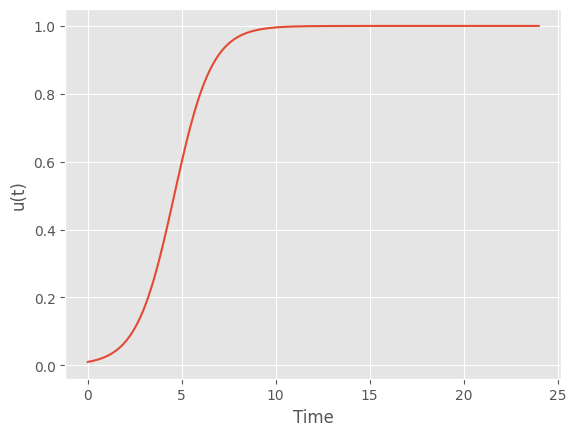

In [13]:
plt.plot(tTrain, uTrain)
#set x label time
plt.xlabel('Time')
#set y label u(t)
plt.ylabel('u(t)')
# sace the image as SGModel.png
plt.savefig('SGModel.png')


Let's tak e more sparse and less data for training:

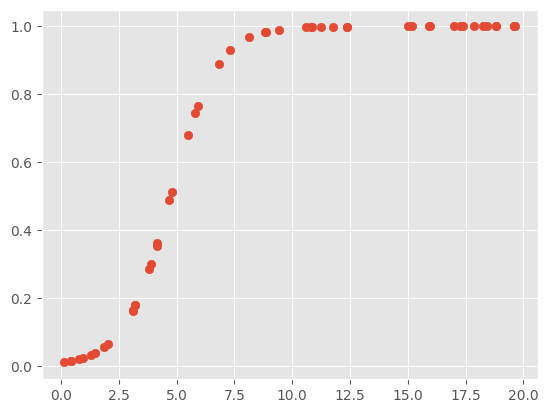

In [7]:
tTrain_sparse = np.sort(np.random.uniform(0,20,50))
sol_sparse = ode_solver(tTrain_sparse, initial_cond, params) # Lösen der DGL
uTrain_sparse = sol_sparse[:, 0]
plt.scatter(tTrain_sparse, uTrain_sparse)

In [8]:
# Add small random noise
noise_level = 0.05  # You can adjust this to control the noise level
noise = np.random.normal(0, noise_level, uTrain_sparse.shape)
noisy_data = uTrain_sparse + noise
noisy_data

array([-0.07375423, -0.0515382 , -0.02409673,  0.02202228, -0.03463476,
       -0.01647742,  0.03705171,  0.03006386,  0.06771472,  0.27334411,
        0.1141268 ,  0.26692493,  0.2451463 ,  0.28869906,  0.29090916,
        0.40121483,  0.34647227,  0.53061782,  0.55995503,  0.66191165,
        0.73952595,  0.82231435,  0.81672239,  0.901327  ,  0.9565231 ,
        0.94479765,  1.00504049,  0.94121006,  0.98204911,  1.15568605,
        0.99134959,  0.96129857,  0.94764909,  1.01276874,  1.03346368,
        1.01269766,  0.97913655,  0.99761516,  0.90578063,  0.99590452,
        0.9144962 ,  1.03751625,  0.99528543,  1.01047006,  0.99706164,
        0.93048482,  0.96580358,  0.93493725,  1.00516605,  1.03409074])

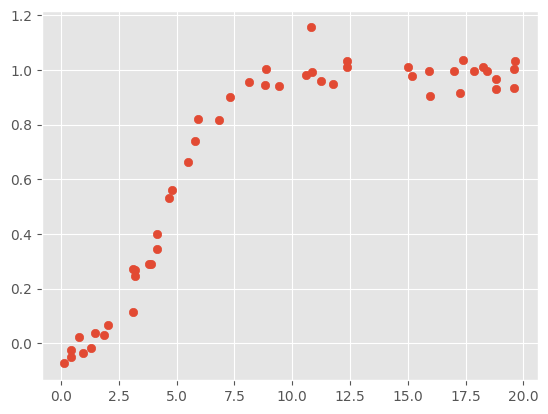

In [9]:
plt.scatter(tTrain_sparse, noisy_data)

Create SciANN model

In [10]:
# Model Input
t = sn.Variable("t", dtype='float64')

# NN model architecture
u = sn.Functional("u", t, 3*[5], 'tanh')

$$ NN1$$
Saturated growth model's fixed parameter
$$C = 1$$

In [13]:
import tensorflow as tf
from keras import backend as K

# initialize the target parameters
C = sn.Parameter(0.5, inputs=t, name="C")

# set up PINN-model
u_t = sn.diff(u,t)

# Define data constraints
d1 = sn.Data(u)

# define model constraints
c1 = sn.Tie(u_t, u*(C-u))

class CustomSciModel(sn.SciModel):
    def set_loss_weights(self, weights):
        if len(weights) != len(self._loss_weights):
            raise ValueError("Weight array length must match the number of output variables")
        for idx, weight in enumerate(weights):
            K.set_value(self._loss_weights[idx], weight)
        self.compile()  # Re-compile the model to apply the new weights

# Usage
model = CustomSciModel(
    inputs=[t],
    targets=[d1, c1],
    loss_func="mse"
)
model.set_loss_weights([1e6, 0.8])


# set the model
# model = sn.SciModel(t, [d1, c1]) # https://www.sciann.com/scimodels/#scimodel

Train the Model

In [14]:
# Model input
input_data = [tTrain_sparse] # tTrain, tTrain_sparse
# Constraints
data_d1 = noisy_data #u uTrain, uTrain_sparse
data_c1 = 'zeros'
# Model output 
target_data = [data_d1, data_c1]

# Train
history = model.train(x_true=input_data,
                      y_true=target_data,
                      epochs=500,
                      batch_size=25,
                      shuffle=True,
                      learning_rate=0.001,
                      reduce_lr_after=100,
                      stop_loss_value=1e-8,
                      verbose=1)


Total samples: 50 
Batch size: 25 
Total batches: 2 

Epoch 1/500
2/2 [==============================] - 1s 16ms/step - batch: 0.5000 - size: 25.0000 - loss: 1178577.0942 - u_loss: 1.1786 - sub_6_loss: 0.0857 - lr: 0.0010 - time: 0.9154
Epoch 2/500
2/2 [==============================] - 0s 0s/step - batch: 0.5000 - size: 25.0000 - loss: 1128659.6186 - u_loss: 1.1287 - sub_6_loss: 0.0697 - lr: 0.0010 - time: 0.0228
Epoch 3/500
2/2 [==============================] - 0s 8ms/step - batch: 0.5000 - size: 25.0000 - loss: 1080048.1266 - u_loss: 1.0800 - sub_6_loss: 0.0559 - lr: 0.0010 - time: 0.1106
Epoch 4/500
2/2 [==============================] - 0s 8ms/step - batch: 0.5000 - size: 25.0000 - loss: 1033239.9038 - u_loss: 1.0332 - sub_6_loss: 0.0445 - lr: 0.0010 - time: 0.1080
Epoch 5/500
2/2 [==============================] - 0s 10ms/step - batch: 0.5000 - size: 25.0000 - loss: 987853.8035 - u_loss: 0.9879 - sub_6_loss: 0.0349 - lr: 0.0010 - time: 0.1054
Epoch 6/500
2/2 [==================

In [15]:
print("C: {}".format(C.value))

C: [0.98540688]
